In [1]:
import numpy as np
import pandas as pd

from shapely import Polygon, LineString
from shapely.ops import unary_union
from shapely import wkt

import utm
import ast

In [2]:
def from_latlon(latitude, longitude, geozone_num, geozone_let):
    """
    convert lat, lon to (x, y) coordinates (in meters)
    :param latitude:  list or np.array (shape: (n,))
    :param longitude: list or np.array (shape: (n,))
    :param geozone_num: geozone integer
    :param geozone_let: geozone letter
    :return: np.array of (x, y) coordinates (shape: (n, 2))
    """
    xy = np.array([
        utm.from_latlon(
            latitude=lat, 
            longitude=lon, 
            force_zone_number=geozone_num,
            force_zone_letter=geozone_let
        )[:2] for lat, lon in zip(latitude, longitude)
    ])
    return xy



def get_subfields_xy(field_bounds: list, geozone_num, geozone_let):
    """
    convert GPS bounds of field into (x, y) coordinates (in meters)
    :param field_bounds: list with GPS bounds of subfields
    :return: list of (x, y) bounds of the subfields
    """
    subfields = [np.array(subfield).T for subfield in field_bounds]
    bounds_xy = [from_latlon(field[1], field[0], geozone_num, geozone_let) for field in subfields]
    return bounds_xy



def get_bounds_from_string(field_bounds_str : str):
    """
    convert string representation of the bounds into list
    :param field_bounds_str: string representation of the bounds
    :return: list of bounds of the subfields
    """
    if field_bounds_str[:4] == '[[[[':
        field_bounds_str = field_bounds_str.replace('[[[', '[[').replace(']]]', ']]')
    field_bounds = ast.literal_eval(field_bounds_str) 
    return field_bounds



def get_geozone(latitude, longitude):
    """
    :param latitude: 
    :param longitude: 
    :return: UTM geozone number and letter
    """
    geozone_num, geozone_let = utm.from_latlon(latitude, longitude)[2:]
    return geozone_num, geozone_let



def get_polygon_from_str_bounds(field_bounds_str, geozone_num, geozone_let):
    # get GPS field bounds from string representation
    field_bounds = get_bounds_from_string(field_bounds_str)
    # convert GPS field bounds to XY and create field_polygon
    subfields_xy = get_subfields_xy(field_bounds, geozone_num, geozone_let)
    field_polygon = unary_union([
        Polygon(subfield).buffer(0) if len(subfield) > 1 else None for subfield in subfields_xy
    ])
    return field_polygon

# Main function : area and distance calculator

In [3]:
def get_area_and_distance(
    tool_width : float,
    gps_m_deviation : float,
    
    time : list,
    track_lat : list,
    track_lon : list,
    
    field_bounds_str : str,
    
    encoded_field_polygon : str = None,
    encoded_calculated_track : str = None,
    
    gps_geozone_num : int = None,
    gps_geozone_let : str = None,
    
    last_point_xy : list = None,
    
    last_path_distance : float = 0
):
    """
    calculates cumulative path distances and processed field area
    :param tool_width: float : tool-width
    :param gps_m_deviation: float : GPS deviation in meters
    :param time: list timestamps
    :param track_lat: list of track latitudes
    :param track_lon: list of track longitudes
    :param field_bounds_str: string with raw GPS field bounds
    :param encoded_field_polygon:  encoded version of the polygon in XY-system
    :param encoded_calculated_track: encoded version of the polygon in XY-system
    :param gps_geozone_num: GPS geozone number (UTM)
    :param gps_geozone_let: GPS geozone letter (UTM)
    :param last_point_xy: XY-coordinates of the last point of calculated track
    :param last_path_distance: last calculated path distance
    :return: list of cumulative path distances and areas, 
            and updated parameters of the track and field
    """
    
    SIMPLIFICATION_M = 0.5
    
    # init field_polygon
    field_polygon = None
    
    # calculate track buffer as the sum of tool-width and GPS deviation
    buffer = (tool_width + gps_m_deviation) / 2
    
    # if GPS geozone is not defined
    if gps_geozone_num is None or gps_geozone_let is None:
        # define geozone num and let
        gps_geozone_num, gps_geozone_let = get_geozone(track_lat[0], track_lon[0])
        # get field polygon from string bounds
        field_polygon = get_polygon_from_str_bounds(field_bounds_str, gps_geozone_num, gps_geozone_let)
        # create encoded version of the field polygon
        encoded_field_polygon = str(field_polygon)
        
    # convert GPS coordinates of the track 
    track_xy = from_latlon(track_lat, track_lon, gps_geozone_num, gps_geozone_let)
    
    
    # if the field polygon isn't defined
    if field_polygon is None:
        # and its encoded version isn't defined
        if encoded_field_polygon is None:
            # get field polygon from string bounds
            field_polygon = get_polygon_from_str_bounds(field_bounds_str, gps_geozone_num, gps_geozone_let)
            # create encoded version of the field polygon
            encoded_field_polygon = str(field_polygon)
        else:
            # load field polygon from encoded version
            field_polygon = wkt.loads(encoded_field_polygon)
    
    
    # if the last processed point isn't defined
    if last_point_xy is None: 
        # then it is the first point of the current track
        last_point_xy = track_xy[0]
    # add last processed point to the track
    track_xy = np.concatenate([[last_point_xy], track_xy])
    
    
    # if the encoded calculated track representation isn't defined
    if encoded_calculated_track is None:
        # create empty calculated track 
        calculated_track = LineString([])
    else:
        # load calculated track from encoded version
        calculated_track = wkt.loads(encoded_calculated_track).simplify(SIMPLIFICATION_M)
        
        
    # create cumulative path distance and area arrays
    path_distance = np.concatenate([[last_path_distance], np.zeros(len(time))])
    field_processed = np.concatenate([[calculated_track.area], np.zeros(len(time))])
    
    # calculation loop : for two consecutive track points (i, i+1)
    for i in range(len(time)):
        # create LineString object as a subtrack
        subtrack = LineString(track_xy[i : i+2])
        # compute distance between these points, and add new cumulative distance to the list
        path_distance[i+1] = path_distance[i] + subtrack.length

        # add buffer to the subtrack, and intersect it with the field polygon
        subfield = subtrack.buffer(buffer) \
                           .intersection(field_polygon) 
        # add this intersection to the preprocessed track
        calculated_track = calculated_track.union(subfield).simplify(SIMPLIFICATION_M)
        # add new cumulative area to the list
        field_processed[i+1] = calculated_track.area   

    # create output dictionary
    distance_and_area_calculator = {
        'encoded_field_polygon' : encoded_field_polygon,
        'encoded_calculated_track' : str(calculated_track),

        'gps_geozone_num' : gps_geozone_num,
        'gps_geozone_let' : gps_geozone_let,

        'last_point_xy' : track_xy[-1],
        
        'path_distance' : path_distance[1:],
        'field_processed' : field_processed[1:]
    }
    
    return distance_and_area_calculator

# Test

In [4]:
df = pd.read_csv('../fields100.csv')
field_bounds_str = df.iloc[0]['geometry_coordinates']
field_bounds_str[:30]

'[[[23.999951022,50.067867025,-'

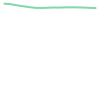

In [5]:
LineString(get_bounds_from_string(field_bounds_str)[0][:300])

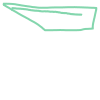

In [6]:
polygon_bds = LineString(get_bounds_from_string(field_bounds_str)[0])


start_point = np.array([50.067829, 23.983841])[::-1]

diff_x = np.random.uniform(0.0100, 0.011000, 900)/700
diff_y = np.random.uniform(-0.00001, 0.000007, 900)

path = [start_point]
for dx, dy in zip(diff_x, diff_y):
    path.append(path[-1] + np.array([dx, dy]))
path = np.array(path)

linepath = LineString(path)
linepath.union(polygon_bds)

# Time test for 3 consecutive 300-coordinate tracks 

In [7]:
# parameters
track_len = 300

tool_width = 10
time = np.ones(track_len)

track_lon, track_lat = list(path[:track_len].T)

## First 300 coords

In [8]:
%%time
first_300 = get_area_and_distance(
    tool_width=tool_width,
    gps_m_deviation=1,
    
    time=time,
    track_lat=track_lat,
    track_lon=track_lon,
    
    field_bounds_str=field_bounds_str
)

CPU times: user 176 ms, sys: 3.1 ms, total: 179 ms
Wall time: 178 ms


## Second 300 coords

In [9]:
track_lon, track_lat = path[track_len : track_len*2].T

In [10]:
%%time
second_300 = get_area_and_distance(
    tool_width=tool_width,
    gps_m_deviation=1,
    
    time=time,
    track_lat=track_lat,
    track_lon=track_lon,
    
    field_bounds_str=field_bounds_str,
    encoded_field_polygon=first_300['encoded_field_polygon'],
    encoded_calculated_track=first_300['encoded_calculated_track'],
    gps_geozone_num=first_300['gps_geozone_num'],
    gps_geozone_let=first_300['gps_geozone_let'],
    last_point_xy=first_300['last_point_xy'],
    last_path_distance=first_300['path_distance'][-1],
)

CPU times: user 156 ms, sys: 1.85 ms, total: 158 ms
Wall time: 157 ms


## Third 300 coords

In [11]:
track_lon, track_lat = path[track_len*2 : track_len*3].T

In [12]:
%%time
third_300 = get_area_and_distance(
    tool_width=tool_width,
    gps_m_deviation=1,
    
    time=time,
    track_lat=track_lat,
    track_lon=track_lon,
    
    field_bounds_str=field_bounds_str,
    encoded_field_polygon=second_300['encoded_field_polygon'],
    encoded_calculated_track=second_300['encoded_calculated_track'],
    gps_geozone_num=second_300['gps_geozone_num'],
    gps_geozone_let=second_300['gps_geozone_let'],
    last_point_xy=second_300['last_point_xy'],
    last_path_distance=second_300['path_distance'][-1],
)

CPU times: user 200 ms, sys: 1.77 ms, total: 202 ms
Wall time: 201 ms


In [13]:
%%time
first_track = wkt.loads(first_300['encoded_calculated_track'])

CPU times: user 124 µs, sys: 17 µs, total: 141 µs
Wall time: 135 µs


In [14]:
%%time
second_track = wkt.loads(second_300['encoded_calculated_track'])

CPU times: user 167 µs, sys: 5 µs, total: 172 µs
Wall time: 170 µs


In [15]:
%%time
third_track = wkt.loads(third_300['encoded_calculated_track'])

CPU times: user 258 µs, sys: 34 µs, total: 292 µs
Wall time: 293 µs


In [16]:
%%time
field_poly = wkt.loads(third_300['encoded_field_polygon'])

CPU times: user 637 µs, sys: 15 µs, total: 652 µs
Wall time: 646 µs


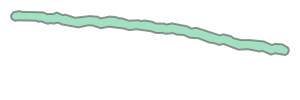

In [17]:
first_track

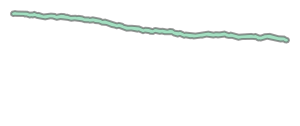

In [18]:
second_track

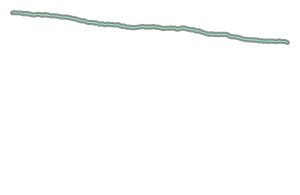

In [19]:
third_track

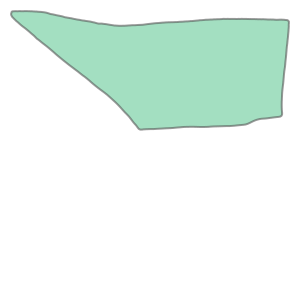

In [20]:
field_poly

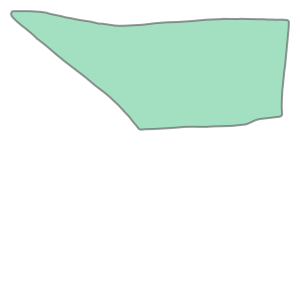

In [21]:
field_poly.simplify(0.5)

# Time test for each step

## First 300 coords

In [22]:
# parameters
track_len = 300

tool_width = 10
gps_m_deviation = 2

time = np.ones(track_len)

track_lon, track_lat = list(path[:track_len].T)

gps_geozone_num = None
gps_geozone_let = None

encoded_field_polygon = None
encoded_calculated_track = None

last_point_xy = None

last_path_distance = 0

In [23]:
%%time
# init field_polygon
field_polygon = None

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 14.8 µs


In [24]:
%%time
# calculate track buffer as the sum of tool-width and GPS deviation
buffer = (tool_width + gps_m_deviation) / 2

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 17.2 µs


In [25]:
%%time
# if GPS geozone is not defined
if gps_geozone_num is None or gps_geozone_let is None:
    # define geozone num and let
    gps_geozone_num, gps_geozone_let = get_geozone(track_lat[0], track_lon[0])
    # get field polygon from string bounds
    field_polygon = get_polygon_from_str_bounds(field_bounds_str, gps_geozone_num, gps_geozone_let)
    # create encoded version of the field polygon
    encoded_field_polygon = str(field_polygon)

CPU times: user 52.3 ms, sys: 2.6 ms, total: 54.9 ms
Wall time: 53.6 ms


In [26]:
%%time
# convert GPS coordinates of the track 
track_xy = from_latlon(track_lat, track_lon, gps_geozone_num, gps_geozone_let)

CPU times: user 14.4 ms, sys: 454 µs, total: 14.8 ms
Wall time: 14.5 ms


In [27]:
%%time
# if the field polygon isn't defined
if field_polygon is None:
    # and its encoded version isn't defined
    if encoded_field_polygon is None:
        # get field polygon from string bounds
        field_polygon = get_polygon_from_str_bounds(field_bounds_str, gps_geozone_num, gps_geozone_let)
        # create encoded version of the field polygon
        encoded_field_polygon = str(field_polygon)
    else:
        # load field polygon from encoded version
        field_polygon = wkt.loads(encoded_field_polygon)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [28]:
%%time
# if the last processed point isn't defined
if last_point_xy is None: 
    # then it is the first point of the current track
    last_point_xy = track_xy[0]
# add last processed point to the track
track_xy = np.concatenate([[last_point_xy], track_xy])

CPU times: user 55 µs, sys: 13 µs, total: 68 µs
Wall time: 62 µs


In [29]:
%%time
# if the encoded calculated track representation isn't defined
if encoded_calculated_track is None:
    # create empty calculated track 
    calculated_track = LineString([])
else:
    # load calculated track from encoded version
    calculated_track = wkt.loads(encoded_calculated_track).simplify(0.1)

CPU times: user 159 µs, sys: 1 µs, total: 160 µs
Wall time: 170 µs


In [30]:
%%time
# create cumulative path distance and area arrays
path_distance = np.concatenate([[last_path_distance], np.zeros(len(time))])
field_processed = np.concatenate([[calculated_track.area], np.zeros(len(time))])

CPU times: user 231 µs, sys: 74 µs, total: 305 µs
Wall time: 247 µs


In [31]:
%%time
# calculation loop : for two consecutive track points (i, i+1)
for i in range(len(time)):
    # create LineString object as a subtrack
    subtrack = LineString(track_xy[i : i+2])
    # compute distance between these points, and add new cumulative distance to the list
    path_distance[i+1] = path_distance[i] + subtrack.length

    # add buffer to the subtrack, and intersect it with the field polygon
    subfield = subtrack.buffer(buffer) \
                       .intersection(field_polygon) 
    # add this intersection to the preprocessed track
    calculated_track = calculated_track.union(subfield).simplify(0.1)
    # add new cumulative area to the list
    field_processed[i+1] = calculated_track.area   

CPU times: user 217 ms, sys: 2.72 ms, total: 220 ms
Wall time: 218 ms


In [32]:
%%time
# create output dictionary
distance_and_area_calculator = {
    'encoded_field_polygon' : encoded_field_polygon,
    'encoded_calculated_track' : str(calculated_track),

    'gps_geozone_num' : gps_geozone_num,
    'gps_geozone_let' : gps_geozone_let,

    'last_point_xy' : track_xy[-1],

    'path_distance' : path_distance[1:],
    'field_processed' : field_processed[1:]
}

CPU times: user 169 µs, sys: 0 ns, total: 169 µs
Wall time: 172 µs


## Second 300 coords

In [33]:
# parameters
track_len = 300

tool_width = 10
gps_m_deviation = 2

time = np.ones(track_len)

track_lon, track_lat = list(path[track_len : track_len*2].T)

gps_geozone_num = distance_and_area_calculator['gps_geozone_num']
gps_geozone_let = distance_and_area_calculator['gps_geozone_let']

encoded_field_polygon = distance_and_area_calculator['encoded_field_polygon']
encoded_calculated_track = distance_and_area_calculator['encoded_calculated_track']

last_point_xy = distance_and_area_calculator['last_point_xy']

last_path_distance = distance_and_area_calculator['path_distance'][-1]

In [34]:
%%time
# init field_polygon
field_polygon = None

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 10 µs


In [35]:
%%time
# calculate track buffer as the sum of tool-width and GPS deviation
buffer = (tool_width + gps_m_deviation) / 2

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [36]:
%%time
# if GPS geozone is not defined
if gps_geozone_num is None or gps_geozone_let is None:
    # define geozone num and let
    gps_geozone_num, gps_geozone_let = get_geozone(track_lat[0], track_lon[0])
    # get field polygon from string bounds
    field_polygon = get_polygon_from_str_bounds(field_bounds_str, gps_geozone_num, gps_geozone_let)
    # create encoded version of the field polygon
    encoded_field_polygon = str(field_polygon)

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 16.2 µs


In [37]:
%%time
# convert GPS coordinates of the track 
track_xy = from_latlon(track_lat, track_lon, gps_geozone_num, gps_geozone_let)

CPU times: user 24.8 ms, sys: 855 µs, total: 25.6 ms
Wall time: 25.2 ms


In [38]:
%%time
# if the field polygon isn't defined
if field_polygon is None:
    # and its encoded version isn't defined
    if encoded_field_polygon is None:
        # get field polygon from string bounds
        field_polygon = get_polygon_from_str_bounds(field_bounds_str, gps_geozone_num, gps_geozone_let)
        # create encoded version of the field polygon
        encoded_field_polygon = str(field_polygon)
    else:
        # load field polygon from encoded version
        field_polygon = wkt.loads(encoded_field_polygon)

CPU times: user 1.96 ms, sys: 258 µs, total: 2.21 ms
Wall time: 2.1 ms


In [39]:
%%time
# if the last processed point isn't defined
if last_point_xy is None: 
    # then it is the first point of the current track
    last_point_xy = track_xy[0]
# add last processed point to the track
track_xy = np.concatenate([[last_point_xy], track_xy])

CPU times: user 70 µs, sys: 13 µs, total: 83 µs
Wall time: 76.1 µs


In [40]:
%%time
# if the encoded calculated track representation isn't defined
if encoded_calculated_track is None:
    # create empty calculated track 
    calculated_track = LineString([])
else:
    # load calculated track from encoded version
    calculated_track = wkt.loads(encoded_calculated_track).simplify(0.1)

CPU times: user 5.03 ms, sys: 1.84 ms, total: 6.87 ms
Wall time: 4.29 ms


In [41]:
%%time
# create cumulative path distance and area arrays
path_distance = np.concatenate([[last_path_distance], np.zeros(len(time))])
field_processed = np.concatenate([[calculated_track.area], np.zeros(len(time))])

CPU times: user 493 µs, sys: 162 µs, total: 655 µs
Wall time: 559 µs


In [42]:
%%time
# calculation loop : for two consecutive track points (i, i+1)
for i in range(len(time)):
    # create LineString object as a subtrack
    subtrack = LineString(track_xy[i : i+2])
    # compute distance between these points, and add new cumulative distance to the list
    path_distance[i+1] = path_distance[i] + subtrack.length

    # add buffer to the subtrack, and intersect it with the field polygon
    subfield = subtrack.buffer(buffer) \
                       .intersection(field_polygon) 
    # add this intersection to the preprocessed track
    calculated_track = calculated_track.union(subfield).simplify(0.1)
    # add new cumulative area to the list
    field_processed[i+1] = calculated_track.area   

CPU times: user 425 ms, sys: 2.62 ms, total: 427 ms
Wall time: 426 ms


In [43]:
%%time
# create output dictionary
distance_and_area_calculator_2 = {
    'encoded_field_polygon' : encoded_field_polygon,
    'encoded_calculated_track' : str(calculated_track),

    'gps_geozone_num' : gps_geozone_num,
    'gps_geozone_let' : gps_geozone_let,

    'last_point_xy' : track_xy[-1],

    'path_distance' : path_distance[1:],
    'field_processed' : field_processed[1:]
}

CPU times: user 213 µs, sys: 0 ns, total: 213 µs
Wall time: 215 µs


## Third 300 coords

In [44]:
# parameters
track_len = 300

tool_width = 10
gps_m_deviation = 2

time = np.ones(track_len)

track_lon, track_lat = list(path[track_len*2 : track_len*3].T)

gps_geozone_num = distance_and_area_calculator_2['gps_geozone_num']
gps_geozone_let = distance_and_area_calculator_2['gps_geozone_let']

encoded_field_polygon = distance_and_area_calculator_2['encoded_field_polygon']
encoded_calculated_track = distance_and_area_calculator_2['encoded_calculated_track']

last_point_xy = distance_and_area_calculator_2['last_point_xy']

last_path_distance = distance_and_area_calculator_2['path_distance'][-1]

In [45]:
%%time
# init field_polygon
field_polygon = None

CPU times: user 14 µs, sys: 1 µs, total: 15 µs
Wall time: 20 µs


In [46]:
%%time
# calculate track buffer as the sum of tool-width and GPS deviation
buffer = (tool_width + gps_m_deviation) / 2

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 21 µs


In [47]:
%%time
# if GPS geozone is not defined
if gps_geozone_num is None or gps_geozone_let is None:
    # define geozone num and let
    gps_geozone_num, gps_geozone_let = get_geozone(track_lat[0], track_lon[0])
    # get field polygon from string bounds
    field_polygon = get_polygon_from_str_bounds(field_bounds_str, gps_geozone_num, gps_geozone_let)
    # create encoded version of the field polygon
    encoded_field_polygon = str(field_polygon)

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 16.9 µs


In [48]:
%%time
# convert GPS coordinates of the track 
track_xy = from_latlon(track_lat, track_lon, gps_geozone_num, gps_geozone_let)

CPU times: user 33.6 ms, sys: 1.97 ms, total: 35.6 ms
Wall time: 33.9 ms


In [49]:
%%time
# if the field polygon isn't defined
if field_polygon is None:
    # and its encoded version isn't defined
    if encoded_field_polygon is None:
        # get field polygon from string bounds
        field_polygon = get_polygon_from_str_bounds(field_bounds_str, gps_geozone_num, gps_geozone_let)
        # create encoded version of the field polygon
        encoded_field_polygon = str(field_polygon)
    else:
        # load field polygon from encoded version
        field_polygon = wkt.loads(encoded_field_polygon)

CPU times: user 3.26 ms, sys: 441 µs, total: 3.7 ms
Wall time: 3.36 ms


In [50]:
%%time
# if the last processed point isn't defined
if last_point_xy is None: 
    # then it is the first point of the current track
    last_point_xy = track_xy[0]
# add last processed point to the track
track_xy = np.concatenate([[last_point_xy], track_xy])

CPU times: user 104 µs, sys: 37 µs, total: 141 µs
Wall time: 122 µs


In [51]:
%%time
# if the encoded calculated track representation isn't defined
if encoded_calculated_track is None:
    # create empty calculated track 
    calculated_track = LineString([])
else:
    # load calculated track from encoded version
    calculated_track = wkt.loads(encoded_calculated_track).simplify(0.1)

CPU times: user 6.79 ms, sys: 1.79 ms, total: 8.58 ms
Wall time: 6.28 ms


In [52]:
%%time
# create cumulative path distance and area arrays
path_distance = np.concatenate([[last_path_distance], np.zeros(len(time))])
field_processed = np.concatenate([[calculated_track.area], np.zeros(len(time))])

CPU times: user 395 µs, sys: 111 µs, total: 506 µs
Wall time: 434 µs


In [53]:
%%time
# calculation loop : for two consecutive track points (i, i+1)
for i in range(len(time)):
    # create LineString object as a subtrack
    subtrack = LineString(track_xy[i : i+2])
    # compute distance between these points, and add new cumulative distance to the list
    path_distance[i+1] = path_distance[i] + subtrack.length

    # add buffer to the subtrack, and intersect it with the field polygon
    subfield = subtrack.buffer(buffer) \
                       .intersection(field_polygon) 
    # add this intersection to the preprocessed track
    calculated_track = calculated_track.union(subfield).simplify(0.1)
    # add new cumulative area to the list
    field_processed[i+1] = calculated_track.area   

CPU times: user 643 ms, sys: 3.72 ms, total: 647 ms
Wall time: 645 ms


In [54]:
%%time
# create output dictionary
distance_and_area_calculator_2 = {
    'encoded_field_polygon' : encoded_field_polygon,
    'encoded_calculated_track' : str(calculated_track),

    'gps_geozone_num' : gps_geozone_num,
    'gps_geozone_let' : gps_geozone_let,

    'last_point_xy' : track_xy[-1],

    'path_distance' : path_distance[1:],
    'field_processed' : field_processed[1:]
}

CPU times: user 304 µs, sys: 1 µs, total: 305 µs
Wall time: 306 µs
